# Advanced Tutorial

> Tutorial on advanced updates, pruning and gradient queries

## Overview

The previous tutorial gave an overview of the main abstractions in `emb_opt` for basic hill climbing. This notebook goes over some more advanced query updating strategies

In [ ]:
from emb_opt.imports import *
from emb_opt.schemas import Query, Item, Batch, ScoreResponse, FilterResponse
from emb_opt.plugins.huggingface import HugggingfaceDataPlugin
from emb_opt.runner import Runner
from emb_opt.utils import build_batch_from_embeddings

import string
from datasets import Dataset

import matplotlib.pyplot as plt

/home/dmai/miniconda3/envs/emb_opt/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Setup

To start, we'll set up the same dataset, filter function and score function from the previous notebook

In [ ]:
def get_dataset(n_vectors: int=10000, size: int=64):
    
    np.random.seed(42)
    vectors = np.random.randn(n_vectors, size)

    vector_data = [{
                    'index' : i,
                    'item' : ''.join(np.random.choice([i for i in string.ascii_lowercase], size=10).tolist()),
                    'rand' : np.random.rand(),
                    'embedding' : vectors[i]
                } for i in range(n_vectors)]

    vector_dataset = Dataset.from_list(vector_data)
    vector_dataset.add_faiss_index('embedding')
    
    return vector_dataset

def get_data_plugin(dataset: Dataset, k: int=10, distance_cutoff: Optional[float]=None):
    data_plugin = HugggingfaceDataPlugin(k=k, 
                                         dataset=dataset, 
                                         index_name='embedding', 
                                         item_key='item', 
                                         id_key='index', 
                                         distance_cutoff=distance_cutoff
                                        )
    return data_plugin

In [ ]:
def score_embeddings(embeddings: np.ndarray, sigma: float=5.) -> np.ndarray:
    target_point = np.ones(embeddings.shape[1])*.75
    
    distances = np.linalg.norm(embeddings - target_point, axis=1) / np.sqrt(embeddings.shape[1])
    
    scores = np.exp(-0.5 * (distances/sigma)**2)
        
    return scores

def score_plugin(inputs: List[Item]) -> List[ScoreResponse]:
    embeddings = np.array([i.embedding for i in inputs])
    scores = score_embeddings(embeddings)    
    results = [ScoreResponse(valid=True, score=i, data=None) for i in scores]
    return results

In [ ]:
def filter_plugin(inputs: List[Item]) -> List[FilterResponse]:
    return [FilterResponse(valid=i.data['rand']<0.9, data={'rand':i.data['rand']}) for i in inputs]

In [ ]:
def get_input_batch(n_queries: int=5, size: int=64):
    np.random.seed(40)
    initial_queries = np.random.randn(n_queries, size)
    input_batch = build_batch_from_embeddings(initial_queries)
    return input_batch

In [ ]:
dataset = get_dataset(n_vectors=10000)

100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 1162.11it/s]


In [ ]:
ground_truth = dataset.map(lambda row: 
                            {'score' : float(score_embeddings(np.array(row['embedding'])[None]))})
ground_truth = ground_truth.filter(lambda row: row['rand']<0.9)
ground_truth = ground_truth.sort('score', reverse=True)

In [ ]:
data_plugin = get_data_plugin(dataset, k=10)

## Batch Creation

Here we create a `Batch` of starting queries

In [ ]:
batch = get_input_batch()

## Modules

Now we want to take our batch and run a database query, filter function query, and score function query. The easiest way to do this is wrapping our various functions in their corresponding `Module` class. `Module` classes handle gathering the correct inputs from a `Batch` and processing the outputs.

Internally, the `Runner` class is organized as:

```
Runner
    DataSourceModule
        DataSourceFunction
    FilterModule
        FilterFunction
    ScoreModule
        ScoreFunction
    PruneModule
        PruneFunction
    UpdateModule
        UpdateFunction
```

In [ ]:
from emb_opt.data_source import DataSourceModule
from emb_opt.filter import FilterModule
from emb_opt.score import ScoreModule

In [ ]:
data_module = DataSourceModule(data_plugin)
filter_module = FilterModule(filter_plugin)
score_module = ScoreModule(score_plugin)

In [ ]:
batch = data_module(batch)
batch = filter_module(batch)
batch = score_module(batch)

Now we have a batch with filtered and scored items. We can verify this by iterating through query results within the batch.

In [ ]:
for _, query_result in batch.enumerate_query_results(skip_removed=False):
    print(f'removed: {query_result.internal.removed}, score: {query_result.score if query_result.score else None}')

removed: False, score: 0.9716392517882978
removed: False, score: 0.9735146862660943
removed: False, score: 0.9778528690676259
removed: False, score: 0.9724728791637264
removed: False, score: 0.9782676902487691
removed: False, score: 0.9737127204592259
removed: False, score: 0.9804037820920216
removed: False, score: 0.9753909225654782
removed: False, score: 0.9694685722987455
removed: True, score: None
removed: True, score: None
removed: False, score: 0.9726323141284812
removed: False, score: 0.9692556815122584
removed: False, score: 0.9745647899839788
removed: False, score: 0.9629961168102679
removed: False, score: 0.9701815738190763
removed: False, score: 0.97486965277314
removed: False, score: 0.9711548702455153
removed: False, score: 0.9694112397200653
removed: True, score: None
removed: False, score: 0.9759289815073339
removed: False, score: 0.9773133941752246
removed: False, score: 0.9739640115726699
removed: False, score: 0.9623959805518694
removed: False, score: 0.97794040705285

## Update Function

Previously, we used the `RLUpdate` class to update our batch like so:

In [ ]:
from emb_opt.update import RLUpdate, UpdateModule

In [ ]:
update_plugin = RLUpdate(lrs=[.25], distance_penalty=0.)
update_module = UpdateModule(update_plugin)
new_batch = update_module(batch)

We can see the new batch contains the same number of new queries as the old batch

In [ ]:
assert len(new_batch)==len(batch)
print(len(new_batch), len(batch))

5 5


### Branching Updates

`emb_opt` supports update methods that generate a variable number of output queries. We can pass more learning rates to `RLUpdate` to take different step sizes based on our gradient.

In [ ]:
update_plugin = RLUpdate(lrs=[0.1, .25, 0.5, 1.], distance_penalty=0.)
update_module = UpdateModule(update_plugin)
new_batch = update_module(batch)
print(len(new_batch), len(batch))

20 5


We can also use the `TopKDiscreteUpdate` to select `k` new queries from each parent query based on top scoring items

In [ ]:
from emb_opt.update import TopKDiscreteUpdate

In [ ]:
update_plugin = TopKDiscreteUpdate(k=4)
update_module = UpdateModule(update_plugin)
new_batch = update_module(batch)
print(len(new_batch), len(batch))

20 5


This allows for a lot of flexibility in how updates are executed, but creates a problem of managing the total number of queries. If the number of queries increases by a constant multiple, the total number of queries quickly gets out of hand and inefficient. We can manage this with the `Prune` step

## Prune Function

A `Prune` function exists to prune queries to control the total query number. Pruning happens after `Filter` and `Score` steps, but before the `Update` step. This allows us to use score information to inform which queries we prune.

We can use any prune method that corresponds to the `PruneFunction` data model

```python
PruneFunction = Callable[List[Query], List[PruneResponse]]

class PruneResponse(BaseModel):
    valid: bool           # if the input `Query` item is valid (if False, the associated `Query` is removed)
    data: Optional[Dict]  # optional dict of data associated with the prune response
```

In [ ]:
from emb_opt.prune import TopKPrune, PruneModule

In [ ]:
prune_plugin = TopKPrune(k=1, score_agg='mean', group_by='collection_id')
prune_module = PruneModule(prune_plugin)

In [ ]:
# starting batch size
print(len(list(batch.valid_queries())))

# create new batch with more queries
new_batch = update_module(batch)
print(len(list(new_batch.valid_queries())))

# query, filter, score
new_batch = data_module(new_batch)
new_batch = filter_module(new_batch)
new_batch = score_module(new_batch)
print(len(list(new_batch.valid_queries())))

# prune
new_batch = prune_module(new_batch)
print(len(list(new_batch.valid_queries())))

5
20
20
5


## Running with branching and pruning

Here we show running with branching and pruning. We use an RL update with several learning rates, and prune back to a single update by mean score. This allows us to converge to the top 1 result with fewer iterations

In [ ]:
update_plugin = RLUpdate(lrs=[0.25, 1., 5.], distance_penalty=0.)
prune_func = TopKPrune(k=1, score_agg='mean', group_by='collection_id')

In [ ]:
runner = Runner(data_plugin, filter_plugin, score_plugin, prune_plugin, update_plugin)

In [ ]:
input_batch = get_input_batch(n_queries=3)

In [ ]:
output_batch, search_log = runner.search(input_batch, 3)

0 0.97 0.97 0.97
1 0.98 0.97 0.98
2 0.98 0.98 0.98


We found the same top 1 result with reduced coverage of the full dataset

In [ ]:
results = search_log.compile_results(skip_removed=False)
len(results)

112

In [ ]:
k_vals = [1, 5, 10, 50]
recovered_ids = set([i['id'] for i in results])
metrics = []

for k in k_vals:
    gt_idxs = set(ground_truth[:k]['index'])
    percent_recovered = len(gt_idxs.intersection(recovered_ids))/k
    metrics.append(percent_recovered)
    
metrics

[1.0, 0.4, 0.3, 0.12]

By plotting trajectories, we can see the branching and pruning

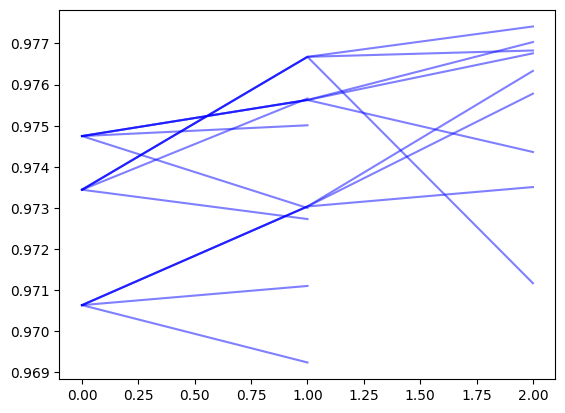

In [ ]:
for final_node in search_log.query_tree.leaf_nodes(include_removed=True):
    mean_scores = []
    
    current = final_node
    while current:
        mean_scores.append(current.mean_score)
        current = current.parent
        
    plt.plot(mean_scores[::-1], color='b', alpha=0.5)

## Gradient Based Queries

So far, we have used gradients to `Update` our queries. We can also use gradients in the query itself. We take a query embedding and project it along the score gradient, creating multiple queries.

For this to work, we need to know the gradient of the query embedding at query time. This is managed by the classes `UpdatePluginGradientWrapper` and `DataPluginGradWrapper`.

`UpdatePluginGradientWrapper` takes a new query and estimates its gradient using scored items from the new query's parent query. The gradient values are stored in the new query's `data['_score_grad']` attribute.

`DataPluginGradWrapper` then uses this gradient to execute the gradient based query.

`UpdatePluginGradientWrapper` can be replaced by any custom method that assigns the gradient to the `data['_score_grad']` attribute of queries. Note that the gradient is expected to point in the direction of _increasing_ score

In [ ]:
from emb_opt.data_source import DataPluginGradWrapper
from emb_opt.update import UpdatePluginGradientWrapper, TopKContinuousUpdate

Here we set up a run with the gradient based query. Since we are using gradients in the query step, we will swap out the RL update (also gradient based) with top k selection

In [ ]:
update_plugin = TopKContinuousUpdate(3) # update averages top 3 embeddings
update_plugin_grad = UpdatePluginGradientWrapper(update_plugin, distance_penalty=0., max_norm=None)

In [ ]:
lrs = np.array([0.1, 0.5, 1, 5])
data_plugin_grad = DataPluginGradWrapper(data_plugin, lrs)

In [ ]:
runner = Runner(data_plugin_grad, filter_plugin, score_plugin, None, update_plugin_grad)

In [ ]:
input_batch = get_input_batch(n_queries=5)

In [ ]:
output_batch, search_log = runner.search(input_batch, 5)

0 0.97 0.97 0.97 0.97 0.98
1 0.97 0.97 0.98 0.97 0.98
2 0.98 0.97 0.97 0.98 0.98
3 0.97 0.98 0.98 0.98 0.98
4 0.97 0.98 0.97 0.98 0.97


In [ ]:
results = search_log.compile_results(skip_removed=False)
len(results)

349

In [ ]:
k_vals = [1, 5, 10, 50]
recovered_ids = set([i['id'] for i in results])
metrics = []

for k in k_vals:
    gt_idxs = set(ground_truth[:k]['index'])
    percent_recovered = len(gt_idxs.intersection(recovered_ids))/k
    metrics.append(percent_recovered)
    
metrics

[1.0, 0.4, 0.4, 0.34]